In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
df = pd.read_csv('./train.csv')

In [4]:
# Load data

data = df.values.astype(np.float32)
np.random.shuffle(data)
X = data[:, 1:]
Y = data[:, 0]

Xtrain = X[:-1000]
Ytrain = Y[:-1000]
Xtest  = X[-1000:]
Ytest  = Y[-1000:]

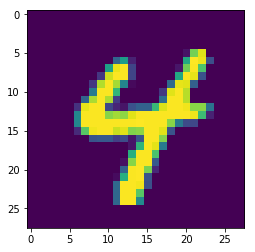

In [5]:
s = np.reshape(Xtrain[0], (28, 28))
plt.imshow(s)
plt.show()

In [8]:
# normalizie the data

mu = Xtrain.mean(axis=0)
std = Xtrain.std(axis=0)

np.place(std, std == 0, 1)

Xtrain = (Xtrain - mu) / std
Xtest = (Xtest - mu) / std

In [9]:
# change y to hot encoder

def y2indicator(y):

    y = y.astype(np.int32)
    ind = np.zeros((len(y), 10))

    for i in range(len(y)):
        ind[i, y[i]] = 1
        
    return ind 

In [10]:
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

In [45]:
# data is ready

Xtrain = Xtrain.astype(np.float32)
Xtest = Xtest.astype(np.float32)
Ytrain = Ytrain.astype(np.float32)
Ytest = Ytest.astype(np.float32)
Ytrain_ind = Ytrain_ind.astype(np.float32)
Ytest_ind = Ytest_ind.astype(np.float32)

In [46]:
max_iter = 15
print_period = 100

lr = 0.00004
reg = 0.01

N, D = Xtrain.shape
batch_sz = 500
n_batches = N // batch_sz

# add an extra layer just for fun
M1 = 300
M2 = 100
K = 10

In [47]:
W1_init = np.random.randn(D, M1) / 28
b1_init = np.zeros(M1)
W2_init = np.random.randn(M1, M2) / np.sqrt(M1)
b2_init = np.zeros(M2)
W3_init = np.random.randn(M2, K) / np.sqrt(M2)
b3_init = np.zeros(K)

In [48]:
# define variables and expressions
X = tf.placeholder(tf.float32, shape=(None, D), name='X')
T = tf.placeholder(tf.float32, shape=(None, K), name='T')
W1 = tf.Variable(W1_init.astype(np.float32))
b1 = tf.Variable(b1_init.astype(np.float32))
W2 = tf.Variable(W2_init.astype(np.float32))
b2 = tf.Variable(b2_init.astype(np.float32))
W3 = tf.Variable(W3_init.astype(np.float32))
b3 = tf.Variable(b3_init.astype(np.float32))

In [49]:
# define the model

Z1 = tf.nn.relu( tf.matmul(X, W1) + b1 )
Z2 = tf.nn.relu( tf.matmul(Z1, W2) + b2 )
Yish = tf.matmul(Z2, W3) + b3
# remember, the cost function does the softmaxing! weird, right?

In [50]:
#dropout 
"""
X_d = tf.nn.dropout(X, 0.8)
Z1 = tf.nn.relu( tf.matmul(X_d, W1) + b1 )
Z1_d = tf.nn.dropout(Z1, 0.5)
Z2 = tf.nn.relu( tf.matmul(Z1_d, W2) + b2 )
Z2_d = tf.nn.dropout(Z2, 0.5)
Yish = tf.matmul(Z2_d, W3) + b3
"""

'\nX_d = tf.nn.dropout(X, 0.8)\nZ1 = tf.nn.relu( tf.matmul(X_d, W1) + b1 )\nZ1_d = tf.nn.dropout(Z1, 0.5)\nZ2 = tf.nn.relu( tf.matmul(Z1_d, W2) + b2 )\nZ2_d = tf.nn.dropout(Z2, 0.5)\nYish = tf.matmul(Z2_d, W3) + b3\n'

In [51]:
# softmax_cross_entropy_with_logits take in the "logits"
# if you wanted to know the actual output of the neural net,
# you could pass "Yish" into tf.nn.softmax(logits)

cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Yish, labels=T)) 

#regularzation L1
#cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Yish, labels=T)) +  reg*(tf.reduce_sum(W1*W1) + tf.reduce_sum(b1*b1) + tf.reduce_sum(W2*W2) + tf.reduce_sum(b2*b2) + tf.reduce_sum(W3*W3) + tf.reduce_sum(b3*b3))

#regularzation L2
#cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Yish, labels=T)) + reg*(tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(b1)) + tf.reduce_sum(tf.abs(W2)) + tf.reduce_sum(tf.abs(b2)) + + tf.reduce_sum(tf.abs(W3)) + tf.reduce_sum(tf.abs(b3)))

In [52]:
# we choose the optimizer but don't implement the algorithm ourselves

#classical gradient descent
#train_op = tf.train.GradientDescentOptimizer(lr).minimize(cost)

# momentum optimizer.  set use_nesterov=True for nesterov momentum
#mu = 0.9
#train_op = tf.train.MomentumOptimizer(lr, mu, use_nesterov=True ).minimize(cost)

# let's go with RMSprop, since we just learned about it.  momentum here is mu. So this is really RMSprop with momentum.  
# if you want no momentum, then set momentum = 0, which is default
#train_op = tf.train.RMSPropOptimizer(lr, decay=0.99, momentum=0.9).minimize(cost)

#Adagrad
#train_op = tf.train.AdagradOptimizer(lr).minimize(cost)

#Adam.  default learning rate is 0.001
train_op = tf.train.AdamOptimizer().minimize(cost)

In [53]:
# we'll use this to calculate the error rate
predict_op = tf.argmax(Yish, 1)

In [54]:
def error_rate(p, t):
    return np.mean(p != t)

Cost / err at iteration i=0, j=0: 2166.502 / 0.772
Cost / err at iteration i=1, j=0: 216.482 / 0.064
Cost / err at iteration i=2, j=0: 160.324 / 0.044
Cost / err at iteration i=3, j=0: 134.741 / 0.039
Cost / err at iteration i=4, j=0: 122.164 / 0.037
Cost / err at iteration i=5, j=0: 114.161 / 0.035
Cost / err at iteration i=6, j=0: 110.524 / 0.034
Cost / err at iteration i=7, j=0: 115.709 / 0.032
Cost / err at iteration i=8, j=0: 116.865 / 0.029
Cost / err at iteration i=9, j=0: 118.004 / 0.031
Cost / err at iteration i=10, j=0: 131.716 / 0.033
Cost / err at iteration i=11, j=0: 129.306 / 0.036
Cost / err at iteration i=12, j=0: 149.395 / 0.039
Cost / err at iteration i=13, j=0: 143.204 / 0.039
Cost / err at iteration i=14, j=0: 137.039 / 0.035


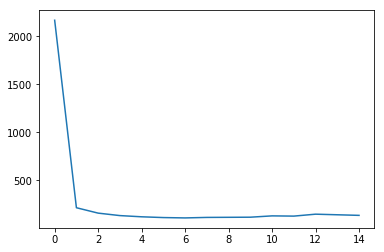

In [55]:
costs = []
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)

    for i in range(max_iter):
        for j in range(n_batches):
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
            Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

            session.run(train_op, feed_dict={X: Xbatch, T: Ybatch})
            if j % print_period == 0:
                test_cost = session.run(cost, feed_dict={X: Xtest, T: Ytest_ind})
                prediction = session.run(predict_op, feed_dict={X: Xtest})
                err = error_rate(prediction, Ytest)
                print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, test_cost, err))
                costs.append(test_cost)

plt.plot(costs)
plt.show()